The number of trends is 88
EVI EMD Analysis success
SVR smoothed aggregated success
Final SVR smoothed residual success
All data output now created in one file.


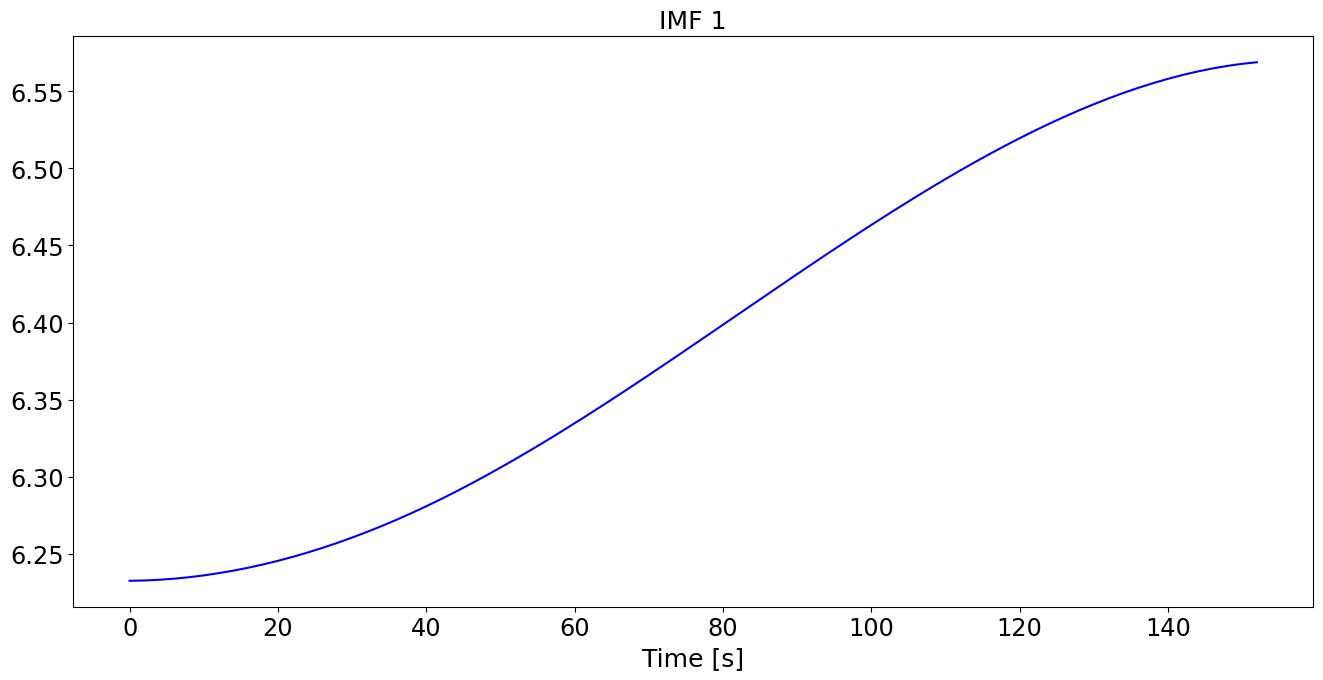

In [10]:
import pandas as pd
from pandas import DataFrame
from PyEMD import EMD
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.pylab as pylab
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as sm
import warnings

# Set plot parameters
params = {
    'legend.fontsize': 'x-large',
    'figure.figsize': (15, 5),
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'xx-large',
    'ytick.labelsize': 'xx-large'
}
pylab.rcParams.update(params)
warnings.filterwarnings('ignore')

# emd File paths
abs_path = "C:/Users/Owner/Desktop/combined/"
emd_file_name = "EMD_IMAR_TimeSeries_EVI_Wide"
emd_file_path = abs_path + emd_file_name + '.csv'


# Midify CODE 1: EMD and Saving Results

# Read original data
original_data = pd.read_csv(filepath_or_buffer=emd_file_path, parse_dates=True)
counties = np.array(original_data.columns[2:])
y = np.array(original_data['22'])
x = np.array(original_data.index)

# Execute EMD on signal
IMF = EMD().emd(y, x)

N = IMF.shape[0] + 1
fig = plt.figure(figsize=(16, 20))
plt.subplots_adjust(hspace=0.7)
plt.title("Alxa Right Banner EVI Original Observations")

test_residual = []

# Residue is saved as the last IMF
for n, imf in enumerate(IMF):
    plt.subplot(N, 1, n + 2)
    plt.plot(imf, 'b')
    plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
    plt.title("IMF " + str(n + 1), fontsize=18)
    if n == (len(IMF) - 1):
        test_residual = imf.tolist()

plt.xlabel("Time [s]", fontsize=18)
fig.savefig(abs_path + "EVI_EMD.jpg")

residual = {}
for county in counties:
    x = np.array(original_data.index)
    y = np.array(original_data[county])
    size = len(x)

    # Execute EMD on signal
    IMF = EMD().emd(y, x)

    N = IMF.shape[0] + 1
    temp = []

    for n, imf in enumerate(IMF):
        # Get current Residual(Trend) in current IMF
        if n == (len(IMF) - 1):
            temp = imf.tolist()

    residual[county] = temp

print("The number of trends is", len(residual))

# Save the results of EMD
writer = pd.ExcelWriter(abs_path + "EMD_Res_" + emd_file_name + '.xlsx')
df = pd.DataFrame(residual)
df.to_excel(writer, 'Sheet1')
writer.close()


IMFs = {}
for county in counties:
    x = np.array(original_data.index)
    y = np.array(original_data[county])

    # Execute EMD on signal
    IMF = EMD().emd(y, x)
    for n, imf in enumerate(IMF):
        temp = imf.tolist()
        temp.append(county)
        temp.append(n+1)
        IMFs['IMF_' + county + '_' + str(n+1)] = temp

df = DataFrame(IMFs)
df.to_csv(abs_path + 'EVI_EMD_IMFs.csv', index=False)
print('EVI EMD Analysis success')

# CODE 2: SVR Modeling

# Read the input file
dictionary = {}

# Load IMFs
svr_file_name = pd.read_csv(abs_path + "EVI_EMD_IMFs.csv")
original_data = svr_file_name
IMFs = original_data.columns

for imf in IMFs:
    x_in = np.arange(0, 153)
    X = np.array(x_in.reshape(153, 1))
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)

    cur_data = np.array(original_data[imf].tolist())
    y = np.array(cur_data[:153])

    cur_countyIndex = str(int(cur_data[153]))
    cur_IMFIndex = str(int(cur_data[154]))

    scaler = StandardScaler()
    Y_scaled = scaler.fit_transform(y.reshape((153, 1)))

    y = Y_scaled.flatten()
    X = X_scaled

    # Search for the best C and gamma
    C_list = np.append(np.arange(1.001, 10, 1), 100)
    gamma_list = np.append(np.arange(1.001, 10, 1), 100)

    grid = GridSearchCV(SVR(kernel='rbf'), param_grid={"C": C_list, "gamma": gamma_list}, cv=4, scoring='explained_variance')
    grid.fit(X, y)
    b1 = grid.best_params_['C']
    g1 = grid.best_params_['gamma']

    C_list2 = np.arange(b1 - 1, b1 + 1, 0.1)
    gamma_list2 = np.arange(g1 - 1, g1 + 1, 0.1)

    grid = GridSearchCV(SVR(kernel='rbf'), param_grid={"C": C_list2, "gamma": gamma_list2}, cv=4, scoring='explained_variance')
    grid.fit(X, y)
    b2 = grid.best_params_['C']
    g2 = grid.best_params_['gamma']

    C_list3 = np.arange(b2 - 0.1, b2 + 0.1, 0.01)
    gamma_list3 = np.arange(g2 - 0.1, g2 + 0.1, 0.01)

    grid = GridSearchCV(SVR(kernel='rbf'), param_grid={"C": C_list3, "gamma": gamma_list3}, cv=4, scoring='explained_variance')
    grid.fit(X, y)
    c = grid.best_params_['C']
    gamma = grid.best_params_['gamma']

    # Perform SVR for IMF
    svr_rbf = SVR(kernel='rbf', C=c, gamma=gamma, epsilon=.1)
    svm = svr_rbf.fit(X, y).predict(X)

    inverseY = (scaler.inverse_transform(y.reshape(153, 1)).flatten()).tolist()
    inverseSVM = (scaler.inverse_transform(svm.reshape(153, 1)).flatten()).tolist()

    y = y.tolist()
    svm = svm.tolist()

    EVS = round(sm.explained_variance_score(y, svm), 2)
    MSE = round(sm.mean_squared_error(y, svm), 2)

    inverseSVM.append(cur_countyIndex)
    inverseSVM.append(cur_IMFIndex)
    inverseSVM.append(EVS)
    inverseSVM.append(MSE)

    dictionary[imf] = inverseSVM

# Save the results of SVR modeling
writer = pd.ExcelWriter(abs_path + "SVR_IMFs_EVI.xlsx")
df = pd.DataFrame(dictionary)
df.to_excel(writer, 'Sheet1')
writer.close()

# Write out CSV file
saveName='SVR_IMFs_EVI.csv'; # SVR_Temperature.xlsx; SVR_Precipitation.xlsx
df=DataFrame(dictionary)
df.to_csv(abs_path + saveName, index=False)

# CODE 3: Aggregate IMF based on county

EVI_SVR = pd.read_csv(abs_path + "SVR_IMFs_EVI.csv")
SVR = EVI_SVR
indexes = SVR.columns
dictionary_sum = {}
dictionary_res = {}
county = '22'
count = 0

# Define an array for IMFs Summation
cur_sum = np.zeros((1, 153)).flatten()

# Define an array for the final IMF
pre_imf = np.zeros((1, 153)).flatten()

size = len(indexes)


for index in indexes:
    cur_list = SVR[index]
    cur_imf = np.array(cur_list[:153])
    cur_county = str(int(cur_list[153]))

    if county == cur_county:
        cur_sum = cur_sum + cur_imf
        count = count + 1

        # Save a previous IMF right before jumping to the next county
        if count >= 3:
            pre_imf = cur_imf

        if count == size:
            dictionary_sum[county] = cur_sum
            dictionary_res[county] = cur_imf

    else:
        dictionary_sum[county] = cur_sum
        dictionary_res[county] = pre_imf
        count = 1
        cur_sum = cur_imf
        county = cur_county

CID = ['22', '23', '24', '81', '82', '83', '84', '85', '86', '87', '137', '138', '139', '144',
       '366', '367', '368', '369', '370', '371', '372', '373', '374', '376', '496', '497',
       '498', '499', '500', '501', '502', '503', '866', '867', '868', '870', '871', '872',
       '875', '876', '877', '878', '879', '880', '881', '882', '883', '884', '885', '886',
       '887', '2039', '2040', '2041', '2042', '2043', '2044', '2045', '2046', '2112',
       '2115', '2116', '2117', '2118', '2119', '2120', '2121', '2122', '2123', '2124',
       '2125', '2202', '2203', '2204', '2205', '2206', '2207', '2208', '2209', '2210',
       '2211', '2212', '2213', '2302', '2303', '2304', '2305', '2306', '2307']

# Write the aggregated results to a file
writer1 = pd.ExcelWriter(abs_path + "SVR_EVI_IMFs_Agg.xlsx")
df1 = pd.DataFrame(dictionary_sum)
df1.to_excel(writer1, 'Sheet1')
writer1.close()
print('SVR smoothed aggregated success')

# Write the final IMF
writer2 = pd.ExcelWriter(abs_path + 'SVR_EVI_IMFs_Res.xlsx')
df2 = pd.DataFrame(dictionary_res)
df2.to_excel(writer2, 'Sheet1')
writer2.close()
print('Final SVR smoothed residual success')

# Save all output files in one Excel file with three tabs
with pd.ExcelWriter(abs_path + 'Combined_Output.xlsx') as writer:
    df.to_excel(writer, sheet_name='EVI_EMD_IMFs', index=False)
    df1.to_excel(writer, sheet_name='SVR_EVI_IMFs_Agg', index=False)
    df2.to_excel(writer, sheet_name='SVR_EVI_IMFs_Res', index=False)

print('All data output now created in one file.')
